# Al-Hitawi Mohammed P622VN -
Cart-Pole Controller Project

- Her are the second vertion for final test you can change btween algothims by boolean
variable  (self.ddqn = True) if true then will train or run Double DQN else 
it will run DQN and for testing you can use the models that I saved them 
- About Envoronment and what I am using it is in report in details

Importing libraries 

In [1]:
import os
import random
import gym
import pylab
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras import backend as K
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\Mohammed\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\Mohammed\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Mohammed\anaconda3\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


# Model Architecture

In [2]:
def DQN_DDQN_Model(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input

    # 'Dense'  layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)
    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)
    model = Model(inputs = X_input, outputs = X)
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        self.env._max_episode_steps = 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 1000
        self.memory = deque(maxlen=2000)
        
        self.gamma         = 0.95    # discount rate
        self.epsilon       = 1.0  # exploration rate
        self.epsilon_min   = 0.01
        self.epsilon_decay = 0.999
        self.batch_size    = 32
        self.train_start   = 1000
# DQN_DDQN_Model
        # defining model parameters
        self.ddqn = True
        self.Soft_Update = False

        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        self.scores, self.episodes, self.average = [], [], []
        
        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"DQN_"+self.env_name+".h5")
        
        # create main model
        self.model = DQN_DDQN_Model(input_shape=(self.state_size,), action_space = self.action_size)
        self.target_model = DQN_DDQN_Model(input_shape=(self.state_size,), action_space = self.action_size)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(self.batch_size, self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        if self.ddqn:
            dqn = 'DDQN_'
        if self.Soft_Update:
            softupdate = '_soft'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every step update target model
                    self.update_target_model()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                     
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, self.epsilon, average))
                    if i == self.env._max_episode_steps:
                        print("Saving trained model as cartpole-ddqn.h5")
                        self.save("cartpole-ddqn.h5")
#                         IF We set ddqn= false we save dqn model 
#                         print("Saving trained model as cartpole-dqn.h5")
#                         self.save("cartpole-dqn.h5")
                        break
                self.replay()

    def test(self):
#       testing DDQN Model
        self.load("cartpole-ddqn.h5")
    
#       testing DQN Model
#       self.load("cartpole-dqn.h5")
        
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

C:\Users\Mohammed\anaconda3\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
C:\Users\Mohammed\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


----------Double DQN--------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 512)               2560      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________

episode: 114/1000, score: 380, e: 0.01, average: 122.6
episode: 115/1000, score: 390, e: 0.01, average: 124.9
episode: 116/1000, score: 334, e: 0.01, average: 126.7
episode: 117/1000, score: 281, e: 0.01, average: 128.0
episode: 118/1000, score: 241, e: 0.01, average: 129.0
episode: 119/1000, score: 294, e: 0.01, average: 130.4
episode: 120/1000, score: 377, e: 0.01, average: 132.4
episode: 121/1000, score: 259, e: 0.01, average: 133.4
episode: 122/1000, score: 618, e: 0.01, average: 137.4
episode: 123/1000, score: 786, e: 0.01, average: 142.6
episode: 124/1000, score: 148, e: 0.01, average: 142.6
episode: 125/1000, score: 109, e: 0.01, average: 142.4
episode: 126/1000, score: 82, e: 0.01, average: 141.9
episode: 127/1000, score: 13, e: 0.01, average: 140.9
episode: 128/1000, score: 89, e: 0.01, average: 140.5
episode: 129/1000, score: 100, e: 0.01, average: 140.2
episode: 130/1000, score: 532, e: 0.01, average: 143.2
episode: 131/1000, score: 1464, e: 0.01, average: 153.2
episode: 132

episode: 262/1000, score: 126, e: 0.01, average: 200.8
episode: 263/1000, score: 128, e: 0.01, average: 200.5
episode: 264/1000, score: 112, e: 0.01, average: 200.2
episode: 265/1000, score: 113, e: 0.01, average: 199.8
episode: 266/1000, score: 137, e: 0.01, average: 199.6
episode: 267/1000, score: 131, e: 0.01, average: 199.3
episode: 268/1000, score: 118, e: 0.01, average: 199.0
episode: 269/1000, score: 117, e: 0.01, average: 198.7
episode: 270/1000, score: 132, e: 0.01, average: 198.5
episode: 271/1000, score: 175, e: 0.01, average: 198.4
episode: 272/1000, score: 141, e: 0.01, average: 198.2
episode: 273/1000, score: 150, e: 0.01, average: 198.0
episode: 274/1000, score: 142, e: 0.01, average: 197.8
episode: 275/1000, score: 141, e: 0.01, average: 197.6
episode: 276/1000, score: 144, e: 0.01, average: 197.4
episode: 277/1000, score: 133, e: 0.01, average: 197.2
episode: 278/1000, score: 172, e: 0.01, average: 197.1
episode: 279/1000, score: 138, e: 0.01, average: 196.9
episode: 2

episode: 411/1000, score: 391, e: 0.01, average: 214.5
episode: 412/1000, score: 365, e: 0.01, average: 214.8
episode: 413/1000, score: 378, e: 0.01, average: 215.2
episode: 414/1000, score: 403, e: 0.01, average: 215.7
episode: 415/1000, score: 299, e: 0.01, average: 215.9
episode: 416/1000, score: 631, e: 0.01, average: 216.9
episode: 417/1000, score: 1535, e: 0.01, average: 220.0
episode: 418/1000, score: 467, e: 0.01, average: 220.6
episode: 419/1000, score: 532, e: 0.01, average: 221.4
episode: 420/1000, score: 667, e: 0.01, average: 222.4
episode: 421/1000, score: 365, e: 0.01, average: 222.8
episode: 422/1000, score: 383, e: 0.01, average: 223.1
episode: 423/1000, score: 360, e: 0.01, average: 223.5
episode: 424/1000, score: 438, e: 0.01, average: 224.0
episode: 425/1000, score: 609, e: 0.01, average: 224.9
episode: 426/1000, score: 287, e: 0.01, average: 225.0
episode: 427/1000, score: 253, e: 0.01, average: 225.1
episode: 428/1000, score: 195, e: 0.01, average: 225.0
episode: 

episode: 560/1000, score: 15, e: 0.01, average: 241.3
episode: 561/1000, score: 19, e: 0.01, average: 240.9
episode: 562/1000, score: 24, e: 0.01, average: 240.5
episode: 563/1000, score: 18, e: 0.01, average: 240.1
episode: 564/1000, score: 205, e: 0.01, average: 240.0
episode: 565/1000, score: 106, e: 0.01, average: 239.8
episode: 566/1000, score: 102, e: 0.01, average: 239.6
episode: 567/1000, score: 89, e: 0.01, average: 239.3
episode: 568/1000, score: 100, e: 0.01, average: 239.0
episode: 569/1000, score: 122, e: 0.01, average: 238.8
episode: 570/1000, score: 153, e: 0.01, average: 238.7
episode: 571/1000, score: 165, e: 0.01, average: 238.6
episode: 572/1000, score: 266, e: 0.01, average: 238.6
episode: 573/1000, score: 192, e: 0.01, average: 238.5
episode: 574/1000, score: 186, e: 0.01, average: 238.4
episode: 575/1000, score: 148, e: 0.01, average: 238.3
episode: 576/1000, score: 217, e: 0.01, average: 238.2
episode: 577/1000, score: 151, e: 0.01, average: 238.1
episode: 578/10

episode: 709/1000, score: 396, e: 0.01, average: 241.6
episode: 710/1000, score: 159, e: 0.01, average: 241.5
episode: 711/1000, score: 327, e: 0.01, average: 241.6
episode: 712/1000, score: 295, e: 0.01, average: 241.7
episode: 713/1000, score: 346, e: 0.01, average: 241.9
episode: 714/1000, score: 296, e: 0.01, average: 241.9
episode: 715/1000, score: 852, e: 0.01, average: 242.8
episode: 716/1000, score: 235, e: 0.01, average: 242.8
episode: 717/1000, score: 178, e: 0.01, average: 242.7
episode: 718/1000, score: 170, e: 0.01, average: 242.6
episode: 719/1000, score: 194, e: 0.01, average: 242.5
episode: 720/1000, score: 225, e: 0.01, average: 242.5
episode: 721/1000, score: 461, e: 0.01, average: 242.8
episode: 722/1000, score: 253, e: 0.01, average: 242.8
episode: 723/1000, score: 213, e: 0.01, average: 242.8
episode: 724/1000, score: 254, e: 0.01, average: 242.8
episode: 725/1000, score: 1350, e: 0.01, average: 244.3
episode: 726/1000, score: 385, e: 0.01, average: 244.5
episode: 

episode: 858/1000, score: 123, e: 0.01, average: 284.0
episode: 859/1000, score: 162, e: 0.01, average: 283.8
episode: 860/1000, score: 155, e: 0.01, average: 283.7
episode: 861/1000, score: 177, e: 0.01, average: 283.5
episode: 862/1000, score: 169, e: 0.01, average: 283.4
episode: 863/1000, score: 140, e: 0.01, average: 283.2
episode: 864/1000, score: 176, e: 0.01, average: 283.1
episode: 865/1000, score: 161, e: 0.01, average: 283.0
episode: 866/1000, score: 156, e: 0.01, average: 282.8
episode: 867/1000, score: 157, e: 0.01, average: 282.7
episode: 868/1000, score: 154, e: 0.01, average: 282.5
episode: 869/1000, score: 146, e: 0.01, average: 282.4
episode: 870/1000, score: 154, e: 0.01, average: 282.2
episode: 871/1000, score: 126, e: 0.01, average: 282.1
episode: 872/1000, score: 124, e: 0.01, average: 281.9
episode: 873/1000, score: 125, e: 0.01, average: 281.7
episode: 874/1000, score: 132, e: 0.01, average: 281.5
episode: 875/1000, score: 149, e: 0.01, average: 281.4
episode: 8

# Shows for Expiremnts 

DQN training


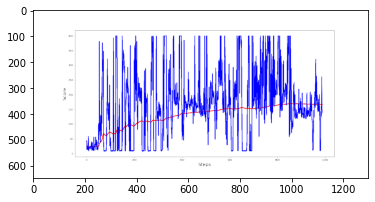

In [4]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DQN_CartPole-v1.png')
print("DQN training with 1000 Epso" )
imgplot = plt.imshow(img)


Double DQN training without soft update with 1000 epizod


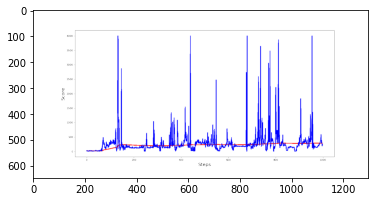

In [10]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DDQN_CartPole-v1.png')
print("Double DQN training without soft update with 1000 epizod" )
imgplot = plt.imshow(img)

Double DQN training with soft update 


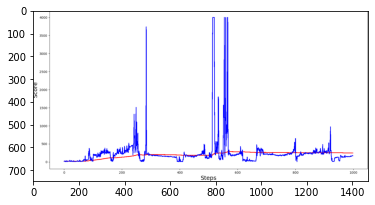

In [7]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DDQN_CartPole-v1_soft.png')
print("Double DQN training with soft update " )
imgplot = plt.imshow(img)

Double DQN training with 500 Episode  


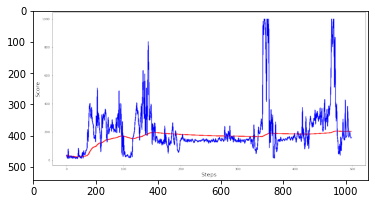

In [16]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DDQN_WITH-500eps.png')
print("Double DQN training with 500 Episode  " )
imgplot = plt.imshow(img)

Dueling DQN training with 500 Epizode  soft update 


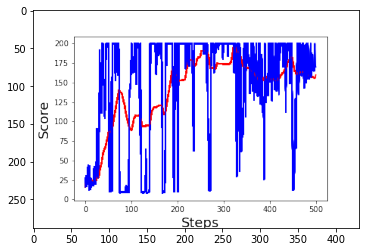

In [13]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DQN_CartPole-v1_Dueling_with500eps.png')
print("Dueling DQN training with 500 Epizode   " )
imgplot = plt.imshow(img)

Dueling DQN training with 1000 Epizode   


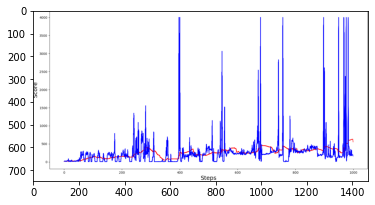

In [15]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DQN_CartPole-v1_DuelingWith100Eps.png')
print("Dueling DQN training with 1000 Epizode   " )
imgplot = plt.imshow(img)

Dueling DQN training with soft udate and 1000 Epizode   


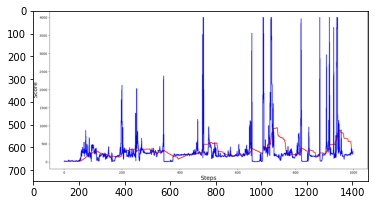

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DDQN_CartPole-v1_DuelingWithSoftUpdate.png')
print("Dueling DQN training with soft update and 1000 Epizode   " )
imgplot = plt.imshow(img)

# Test the models 
her we can test different model but notice we have to change directories in each time we want to test 

try this 
- cartpole-ddqn.h5
- cartpole-dqn.h5
- Dueling DQN_CartPole-v1.h5

In [ ]:
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
#     agent.run()
    agent.test()

# Actor Critic Method 

In [5]:
def ActorModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    #X = Conv2D(32, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    #X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    #X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    return Actor

# Policy Gradient Main Optimization Algorithm

In [7]:
class PGAgent:
    
    def __init__(self, env_name):
        # Initialization
        # Environment and PG parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 100 , -21.0 #10000, -21.0 # specific for pong
        self.lr = 0.000025

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Instantiate games and plot memory
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)
        
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_PG_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor network model
        self.Actor = ActorModel(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)

    def remember(self, state, action, reward):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation
        return discounted_r

    def replay(self):
        # reshape memory to appropriate shape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # training PG network
        self.Actor.fit(states, actions, sample_weight=discounted_r, epochs=1, verbose=0)
        # reset training memory
        self.states, self.actions, self.rewards = [], [], []
    
    def load(self, Actor_name):
        self.Actor = load_model(Actor_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow(self.Model_name+str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame):
        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function 
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        
        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)     

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        #  image frame   
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.reset()
            done, score, SAVING = False, 0, ''
            while not done:
                #self.env.render()
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.PlotModel(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    self.replay()
        
        # close environemnt when finish training
        self.env.close()

    def test(self, Model_name):
        self.load(Model_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

<Figure size 1296x648 with 0 Axes>

# Runing actor crtic model 

In [9]:
# if __name__ == "__main__":
#     #env_name = 'Pong-v0'
#     env_name = 'CartPole-v1'
#     agent = PGAgent(env_name)
#     agent.run()

# Testing actor crtic model 

In [10]:
# Model_Name = "actor_critic.h5"
# if __name__ == "__main__":
#     #env_name = 'Pong-v0'
#     env_name = 'CartPole-v1'
#     agent = PGAgent(env_name)
#     agent.test(Model_Name)